# 导入库包配置GPU

In [27]:
# # Statistics tools
# from scipy import stats
# from scipy.stats import skew,norm
# from scipy.special import boxcox1p
# from scipy.stats import boxcox_normmax
# import scipy.stats as stats

# Visualizing tools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as ppf
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# # 设置中文和'-'负号显示问题
# from pylab import mpl
# mpl.rcParams['font.sans-serif'] = ['FangSong']  # 设置matplotlib可以显示汉语
# mpl.rcParams['axes.unicode_minus'] = True

# Preprocessing tools

import math
import time
import numpy as np
import pandas as pd

# DL/ML Algoirthm
import torch
from torch import nn
from torch.utils import data as tud
from torchkeras import summary
from d2l import torch as d2l
from tsai.all import *
from sklearn import metrics as skm
from IPython.display import clear_output

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings(action="ignore")

gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
gpu, device

(True, device(type='cuda', index=0))

# 数据导入

In [16]:
cols = ["One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Rect", "Time_ns"]

train1_data = pd.read_csv("DLdata/Train1.csv", header=None)
train2_data = pd.read_csv("DLdata/Train2.csv", header=None)
train3_data = pd.read_csv("DLdata/Train3.csv", header=None)
train_data = pd.read_csv("DLdata/Train.csv", header=None)

test_data = pd.read_csv("DLdata/Test.csv", header=None)
valid_data = pd.read_csv("DLdata/Valid.csv", header=None)

train1_data.columns = train2_data.columns = train3_data.columns = cols
train_data.columns = test_data.columns = valid_data.columns = cols

- train_data.shape：查看数据的形状
- train_data.head()：查看数据本身
- train_data.info()：数据集的简单描述， 总行数，空值或者数据类型等
- train_data.value_counts()：分类的时候用的多，查看类别的个数
- train_data.describe()：简单的统计性表述，最大值，最小，平均等
- train_data.corr(method='pearson')：查看列之间的相关性
- train_data.skew()：通过分析数据的高斯分布来确认数据的偏离情况

In [17]:
# 做分类处理
# 0->0，1->0，2->0，8->0，9->0
# 3->5，4->5，5->5，6->5，7->5

def RoundClassification(OriginData):
    Index = []
    # 1->0
    Index = OriginData % 10 == 1
    OriginData[Index] = OriginData[Index] - 1
    # 2->0
    Index = OriginData % 10 == 2
    OriginData[Index] = OriginData[Index] - 2
    # 8->0
    Index = OriginData % 10 == 8
    OriginData[Index] = OriginData[Index] + 2
    # 9->0
    Index = OriginData % 10 == 9
    OriginData[Index] = OriginData[Index] + 1
    # 3->5
    Index = OriginData % 10 == 3
    OriginData[Index] = OriginData[Index] + 2
    # 4->5
    Index = OriginData % 10 == 4
    OriginData[Index] = OriginData[Index] + 1
    # 6->5
    Index = OriginData % 10 == 6
    OriginData[Index] = OriginData[Index] - 1
    # 7->5
    Index = OriginData % 10 == 7
    OriginData[Index] = OriginData[Index] - 2

    
RoundClassification(train1_data.Rect)
RoundClassification(train2_data.Rect)
RoundClassification(train3_data.Rect)
RoundClassification(train_data.Rect)

RoundClassification(test_data.Rect)
RoundClassification(valid_data.Rect)

train_data, test_data, valid_data

(      One  Two  Three  Four  Five  Six  Seven  Eight  Rect      Time_ns
 0      84  268    736   161    57  285     76    209    20    332902500
 1      90  262    717   147    54  292     78    216    20    345693900
 2      96  291    708   173    61  297     80    205    20    378956900
 3      96  361    719   164    58  302     80    208    20    399868600
 4      85  374    746   148    55  309     75    215    25    421466300
 ...   ...  ...    ...   ...   ...  ...    ...    ...   ...          ...
 8926  212  596    640   186    65  573    360    488    30  59938979500
 8927  215  588    647   189    69  588    434    561    30  59958747600
 8928  194  589    653   185    60  601    477    573    30  59979173500
 8929  200  464    649   160    53  629    499    579    30  59997057800
 8930  197  438    629   143    53  661    508    606    35  60017252700
 
 [8931 rows x 10 columns],
       One  Two  Three  Four  Five  Six  Seven  Eight  Rect      Time_ns
 0     108  350    736

In [18]:
train_features = torch.tensor(train_data.drop(['Rect', 'Time_ns'], axis=1).values, dtype=torch.float32)
train_labels = torch.tensor(train_data.Rect.values.reshape(-1, 1), dtype=torch.int32)
train_six_features = torch.tensor(train_data.drop(['Two', 'Five', 'Rect', 'Time_ns'], axis=1).values, dtype=torch.float32)
train_two_features = torch.cat((train_six_features[:,1].reshape(-1, 1), train_six_features[:,2].reshape(-1, 1)), dim = 1)

test_features = torch.tensor(test_data.drop(['Rect', 'Time_ns'], axis=1).values, dtype=torch.float32)
test_labels = torch.tensor(test_data.Rect.values.reshape(-1, 1), dtype=torch.int32)
test_six_features = torch.tensor(test_data.drop(['Two', 'Five', 'Rect', 'Time_ns'], axis=1).values, dtype=torch.float32)
test_two_features = torch.cat((test_six_features[:,1].reshape(-1, 1), test_six_features[:,2].reshape(-1, 1)), dim = 1)

valid_features = torch.tensor(valid_data.drop(['Rect', 'Time_ns'], axis=1).values, dtype=torch.float32)
valid_labels = torch.tensor(valid_data.Rect.values.reshape(-1, 1), dtype=torch.int32)
valid_six_features = torch.tensor(valid_data.drop(['Two', 'Five', 'Rect', 'Time_ns'], axis=1).values, dtype=torch.float32)
valid_two_features = torch.cat((valid_six_features[:,1].reshape(-1, 1), valid_six_features[:,2].reshape(-1, 1)), dim = 1)

# train_features.shape, train_labels.shape, test_features.shape, test_labels.shape, valid_features.shape, valid_labels.shape

In [19]:
# # 展示数据报告
# ppf.ProfileReport(train_data)

# 数据预处理

In [20]:
# train_DataLoader = tud.DataLoader(tud.TensorDataset(train_features, train_labels) , batch_size=64, shuffle=True, num_workers=2, drop_last=True)

# # 测试数据，发现有点问题，前面两组数据始终为0，因此加了一句判断
# for features, labels in train_DataLoader:
#     print(features,labels)

# tsai建模

In [21]:
train_features = train_features.numpy();
test_features = test_features.numpy();
train_labels = train_labels.reshape(-1).numpy();
test_labels = test_labels.reshape(-1).numpy();

tsai_X, tsai_y, tsai_splite = combine_split_data([train_features, test_features], [train_labels, test_labels])

In [22]:
tfms = [None, [Categorize()]]
dsets = TSDatasets(tsai_X, tsai_y, tfms=tfms, splits=tsai_splite, inplace=True)

In [23]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)

In [25]:
my_setup()

os             : Windows-10-10.0.19043-SP0
python         : 3.8.12
tsai           : 0.3.0
fastai         : 2.5.3
fastcore       : 1.3.29
torch          : 1.10.2+cu113
n_cpus         : 16
device         : cuda (NVIDIA GeForce RTX 3070 Laptop GPU)


In [ ]:
archs = [(FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}), 
         (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}), 
         (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
         (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {}), (mWDN, {'levels': 4})]

results = pd.DataFrame(columns=['arch', 'hyperparams', 'train loss', 'valid loss', 'accuracy', 'time'])
for i, (arch, k) in enumerate(archs):
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(100, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    clear_output()
    display(results)

,arch,hyperparams,train loss,valid loss,accuracy,time
0,FCN,{},1.052725,2.87502,0.211622,93


ResNet


epoch,train_loss,valid_loss,accuracy,time
0,2.545128,2.536006,0.191468,00:02
1,2.235983,2.346541,0.207592,00:02
2,2.046282,2.220940,0.234128,00:02
3,1.925137,2.160790,0.234128,00:02
4,1.843237,2.132915,0.234800,00:02
5,1.779363,2.196629,0.238159,00:02
6,1.740150,2.144135,0.246557,00:02
7,1.723845,2.178999,0.245213,00:02
8,1.706505,2.231641,0.229762,00:02
9,1.706836,2.214585,0.233121,00:02


In [10]:
model = XceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.save('sEMGDL')

Path('models/sEMGDL.pth')

SuggestedLRs(valley=0.0010000000474974513)

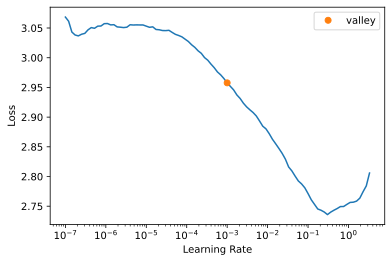

In [11]:
learn.load('sEMGDL')
learn.lr_find()

In [12]:
learn.fit_one_cycle(25, lr_max=0.0010000000474974513)
learn.save('sEMGDL_FIT')

epoch,train_loss,valid_loss,accuracy,time
0,2.645957,2.641129,0.190796,00:03
1,2.443066,2.538166,0.195835,00:02
2,2.320451,2.453709,0.212966,00:02
3,2.215604,2.351557,0.231441,00:02
4,2.135291,2.380153,0.216661,00:02
5,2.060627,2.326562,0.230097,00:02
6,2.024594,2.249257,0.240175,00:02
7,1.988744,2.297483,0.250588,00:02
8,1.968913,2.295422,0.230433,00:02
9,1.928205,2.240316,0.236816,00:02


Path('models/sEMGDL_FIT.pth')

X.shape: (2977, 1, 8)
y.shape: (2977,)
Selected metric: accuracy
Computing feature importance (permutation method)...


  0 feature: BASELINE             accuracy: 0.231105


  0 feature: var_0                accuracy: 0.046355



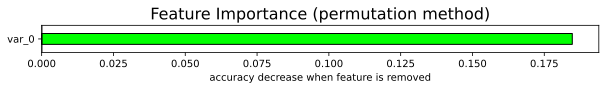

,Feature,accuracy,accuracy_change
0,var_0,0.046355,0.18475
1,BASELINE,0.231105,-0.00000


In [13]:
learn.feature_importance()

X.shape: (2977, 1, 8)
y.shape: (2977,)
Selected metric: accuracy
Computing step importance...


  0 step: BASELINE             accuracy: 0.231105


  1 step: 0                    accuracy: 0.211287


  2 step: 1                    accuracy: 0.182398


  3 step: 2                    accuracy: 0.189117


  4 step: 3                    accuracy: 0.204232


  5 step: 4                    accuracy: 0.208599


  6 step: 5                    accuracy: 0.158549


  7 step: 6                    accuracy: 0.181391


  8 step: 7                    accuracy: 0.180719



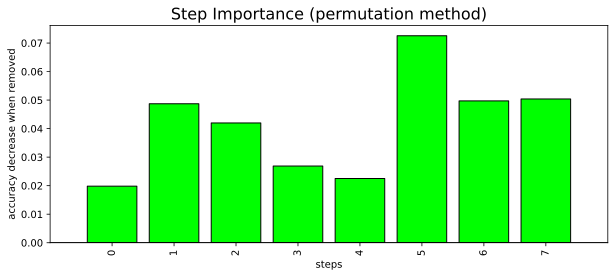

,Step,accuracy,accuracy_change
0,5,0.158549,0.072556
1,7,0.180719,0.050386
2,6,0.181391,0.049714
3,1,0.182398,0.048707
4,2,0.189117,0.041989
5,3,0.204232,0.026873
6,4,0.208599,0.022506
7,0,0.211287,0.019819
8,BASELINE,0.231105,-0.000000


In [14]:
learn.step_importance()

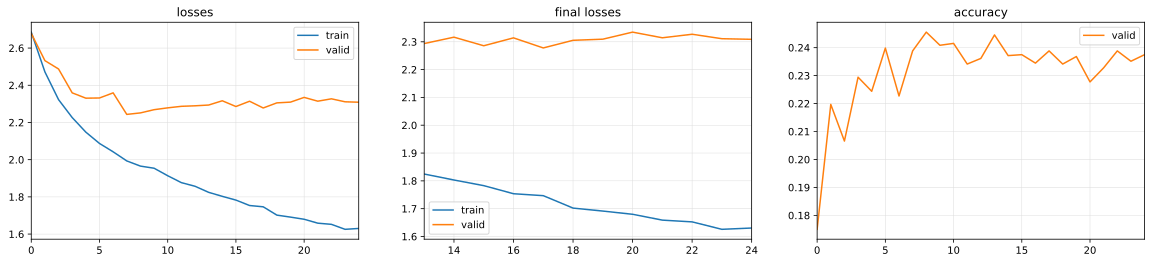

In [59]:
learn.recorder.plot_metrics()

In [65]:
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [66]:
del learn, dsets, dls

In [67]:
learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

(TSTensor(samples:128, vars:1, len:8, device=cuda:0),
 TensorCategory([ 4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,
          7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11,
         11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14,
         15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18,
         18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 19, 19, 19, 19, 19, 18, 18, 18,
         18, 18, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 14,
         14, 14, 14, 14, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 11, 11, 11, 11,
         11, 10], device='cuda:0'))

In [68]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds

(TensorBase([[0.0041, 0.0041, 0.0085,  ..., 0.0040, 0.0040, 0.0029],
         [0.0062, 0.0067, 0.0150,  ..., 0.0065, 0.0061, 0.0044],
         [0.0139, 0.0273, 0.0818,  ..., 0.0193, 0.0159, 0.0109],
         ...,
         [0.0066, 0.0061, 0.0126,  ..., 0.0061, 0.0064, 0.0059],
         [0.0106, 0.0079, 0.0142,  ..., 0.0078, 0.0090, 0.0078],
         [0.0072, 0.0063, 0.0021,  ..., 0.0023, 0.0026, 0.0020]]),
 TensorCategory([4, 4, 4,  ..., 6, 6, 6]),
 TensorBase([4, 4, 4,  ..., 5, 5, 5]))

In [69]:
(valid_targets == valid_preds).float().mean()

TensorCategory(0.2284)

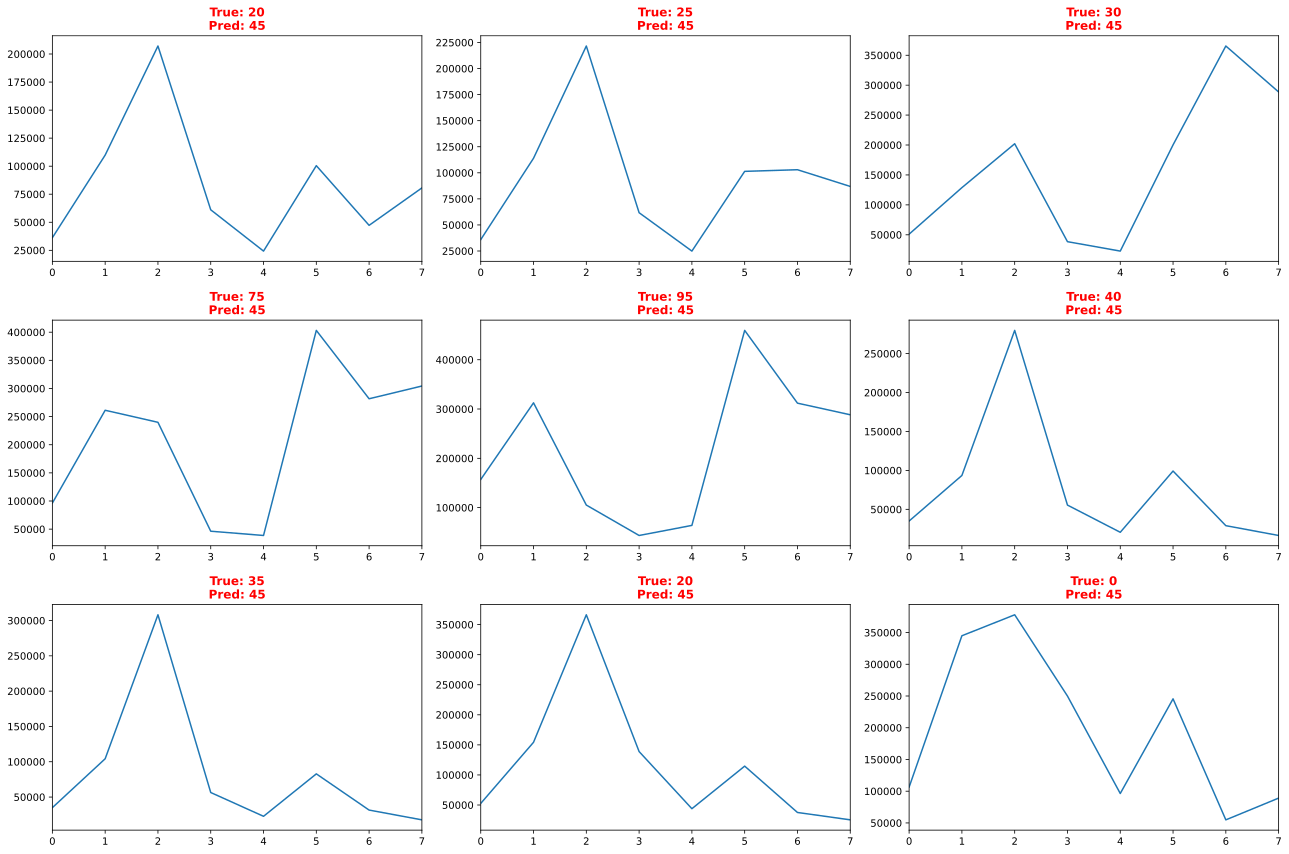

In [70]:
learn.show_results()

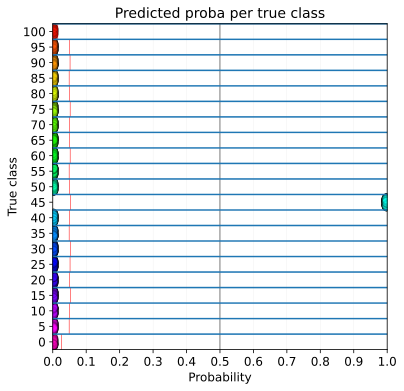

In [71]:
learn.show_probas()

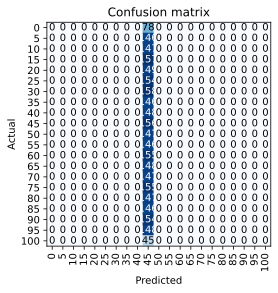

In [72]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [74]:
interp.most_confused(min_val=3)

[(30, 45, 158),
 (15, 45, 157),
 (60, 45, 155),
 (75, 45, 155),
 (25, 45, 154),
 (90, 45, 154),
 (20, 45, 149),
 (40, 45, 148),
 (65, 45, 148),
 (95, 45, 148),
 (10, 45, 147),
 (50, 45, 147),
 (70, 45, 147),
 (80, 45, 147),
 (5, 45, 146),
 (35, 45, 146),
 (55, 45, 146),
 (85, 45, 146),
 (0, 45, 78),
 (100, 45, 45)]

In [76]:
test_ds = valid_dl.dataset.add_test(tsai_X, tsai_y)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:128, vars:1, len:8, device=cuda:0),
 TensorCategory([ 4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,
          7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11,
         11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14,
         15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18,
         18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 19, 19, 19, 19, 19, 18, 18, 18,
         18, 18, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 14,
         14, 14, 14, 14, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 11, 11, 11, 11,
         11, 10], device='cuda:0'))

In [78]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(TensorBase([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 TensorCategory([4, 4, 4,  ..., 6, 6, 6]),
 TensorBase([9, 9, 9,  ..., 9, 9, 9]))

In [83]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')

accuracy:   0.051814


In [84]:
test_ds = dls.dataset.add_test(tsai_X)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:128, vars:1, len:8, device=cuda:0),)

In [85]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas

TensorBase([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

# 模型建立

In [11]:
# Encoder Decoder Architecture + ResNet

class HbConNet(nn.Module):
    def __init__(self):
        super(HbConNetb, self).__init__()
        
        
    
    def forward(self, x):
        
        return x


    